# Python Notebook 6: Optimisation

Course on Statistical Machine Learning\
University of Oxford\
Author: F. Caron


In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product
from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

font = {'size'   : 18}
plt.rc('font', **font)

# Default plotting parameters
font = {'size'   : 18}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100
# For saving the figures
svfigs = False # True if you want to save figures
svdir = './figures/' # directory to save the figures
if svfigs: # set a higher resolution if saving the figures
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.bbox'] = 'tight'
else:
    plt.rcParams['figure.dpi'] = 75 

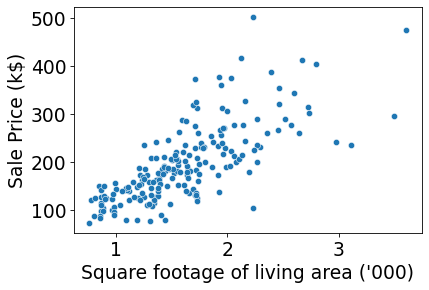

In [2]:
# Download the data from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
filepath = "../datasets/KaggleHousePrices/train.csv" # Change this
houseprices = pd.read_csv(filepath)
houseprices.SalePrice = houseprices.SalePrice/1000 # rescale
houseprices.GrLivArea = houseprices.GrLivArea/1000 # rescale
houseprices = houseprices[0:200]
X = houseprices.GrLivArea.to_numpy()
y = houseprices.SalePrice.to_numpy()

# Plot the data
plt.figure()
sns.scatterplot(data=houseprices, x='GrLivArea', y='SalePrice') 
plt.xlabel("Square footage of living area (\'000)")
plt.ylabel("Sale Price (k$)")
if svfigs:
    plt.savefig(svdir + 'housepricingdata.png', bbox_inches = 'tight')

beta_0= 11.525788028139033
beta_1= 113.54803570228933


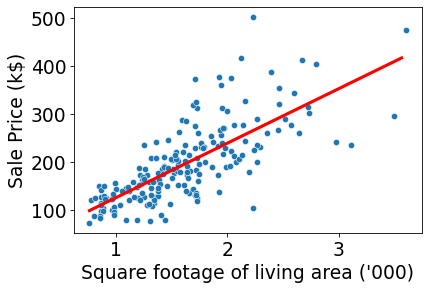

In [3]:
# Fit a linear regression model using the normal equations
regr = linear_model.LinearRegression()
regr.fit(X.reshape(-1,1), y)

print('beta_0=', regr.intercept_)
print('beta_1=', regr.coef_[0])

# Plot data and fitted prediction rule
plt.figure()
sns.scatterplot(data=houseprices, x='GrLivArea', y='SalePrice') 
plt.xlabel("Square footage of living area (\'000)")
plt.ylabel("Sale Price (k$)")
x0 = np.arange(np.min(X), np.max(X), .1)
y0 = regr.predict(x0.reshape(-1,1))
plt.plot(x0,y0, color='red', linewidth = 3)
if svfigs:
    plt.savefig(svdir + 'housepricingOLS.png', bbox_inches = 'tight')

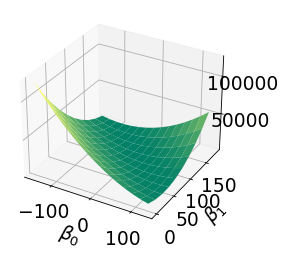

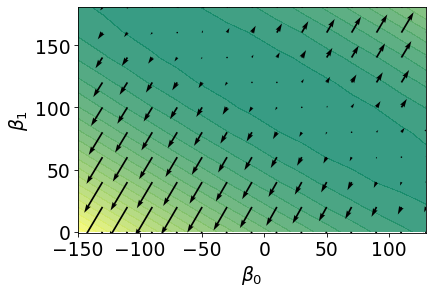

In [4]:
# Show the empirical risk and the gradient as a function of the two parameters
colormap = 'summer'
beta0_range = np.arange(-150,150, 20)
beta1_range = np.arange(0,200, 20)
N, M = len(beta0_range), len(beta1_range)
Z = np.zeros((N, M))
Z_grad1 = np.zeros((N, M))
Z_grad2 = np.zeros((N, M))

for i, (beta0, beta1) in enumerate(product(beta0_range,beta1_range)):
    ypred = beta0+X*beta1
    Z[np.unravel_index(i, (N,M))] = ((y-ypred)**2).mean()
    Z_grad1[np.unravel_index(i, (N,M))] = (2*(ypred-y)).mean()
    Z_grad2[np.unravel_index(i, (N,M))] = (2*X*(ypred-y)).mean()

Z = Z.T
Z_grad1 = Z_grad1.T
Z_grad2 = Z_grad2.T
    
(b0_mg, b1_mg) = np.meshgrid(beta0_range, beta1_range)

# Objective function to optimise in 3D
plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(b0_mg, b1_mg, Z, rstride=1, cstride=1,edgecolor='none', cmap=colormap)   
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$') 
if svfigs:
    plt.savefig(svdir + 'housepricingemprisk2.png', bbox_inches = 'tight')

# Contour plot of the objective function and gradient
plt.figure()
plt.contourf(b0_mg, b1_mg, Z, alpha = 0.8, levels=20, cmap=colormap)   
plt.quiver(b0_mg, b1_mg,Z_grad1,Z_grad2, angles='xy')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$') 
plt.axis('equal')
if svfigs:
    plt.savefig(svdir + 'housepricingcontourgrad.png', bbox_inches = 'tight')

# Gradient descent demo

## Without normalisation

In [5]:
# Fit the linear regression model (to show the minimum)
regr = linear_model.LinearRegression()
regr.fit(X.reshape(-1,1), y)

n=X.size
Phi = np.concatenate((np.ones(shape=(n, 1)), X.reshape(-1,1)),axis=1)
print('Phi^T Phi: \n', Phi.T @ Phi)

Phi^T Phi: 
 [[200.      320.27   ]
 [320.27    566.89104]]


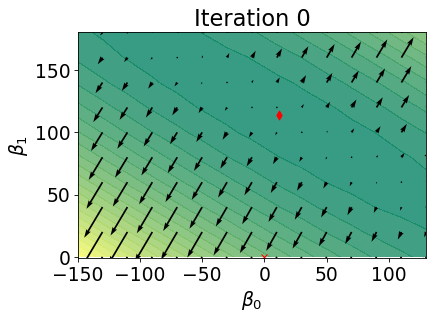

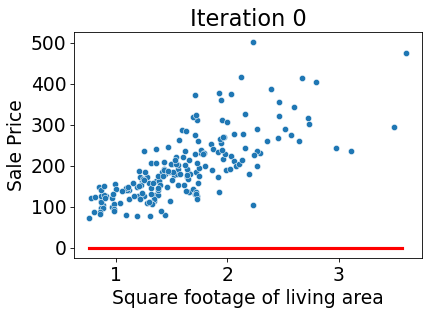

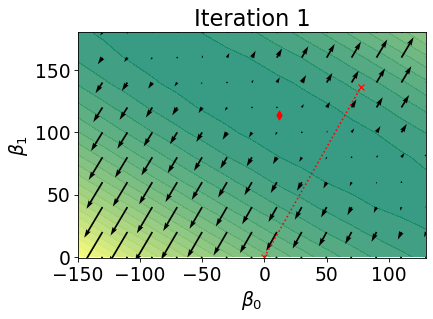

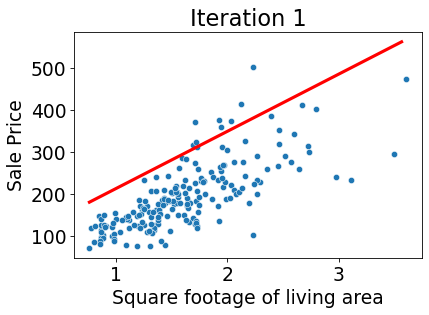

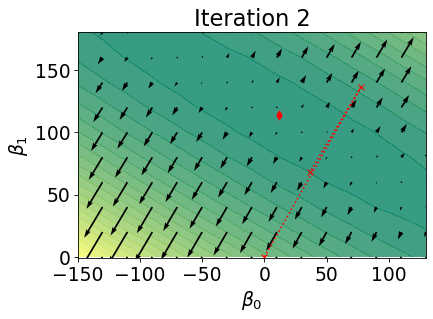

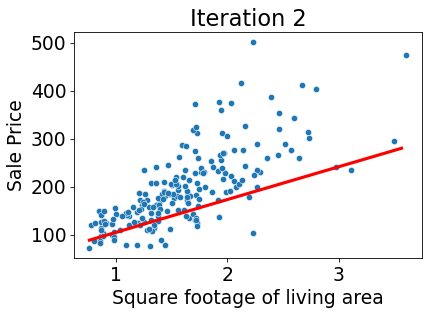

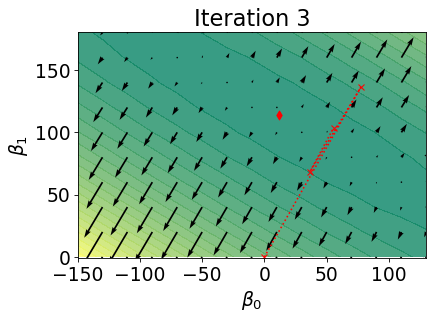

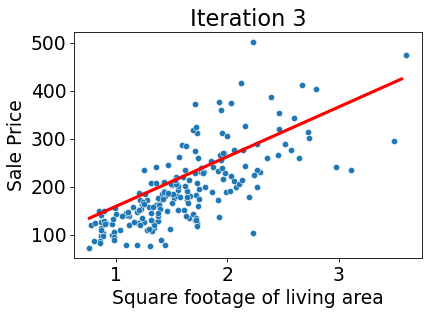

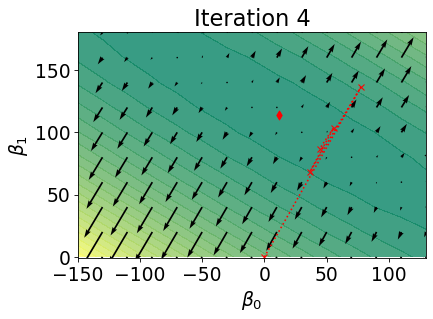

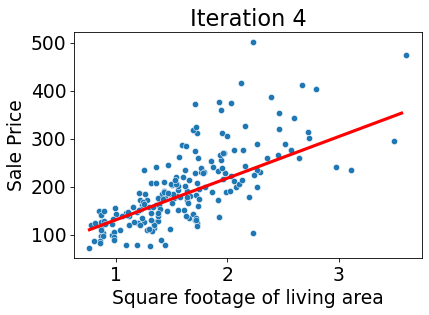

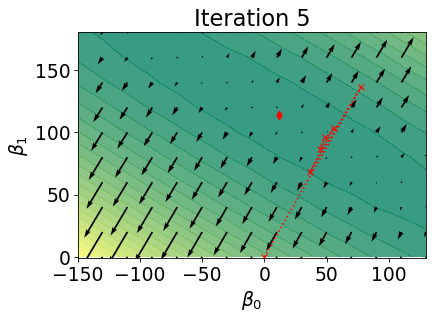

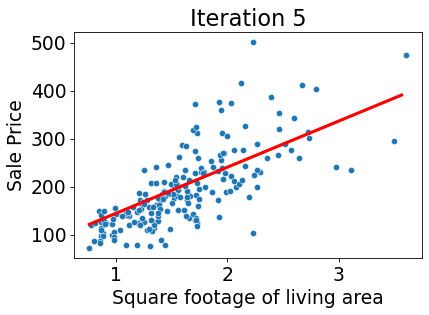

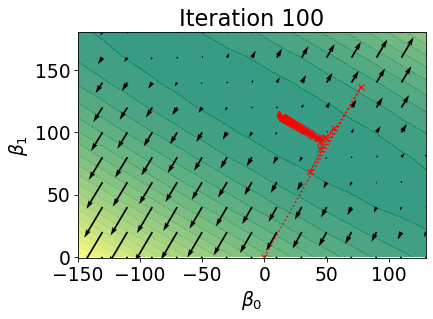

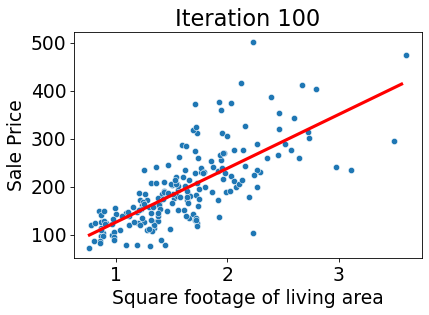

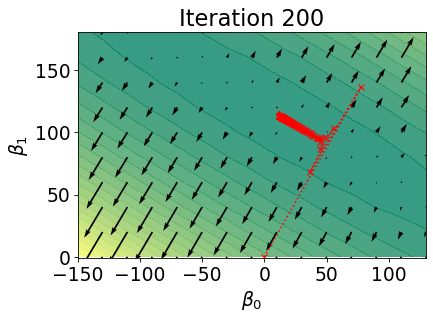

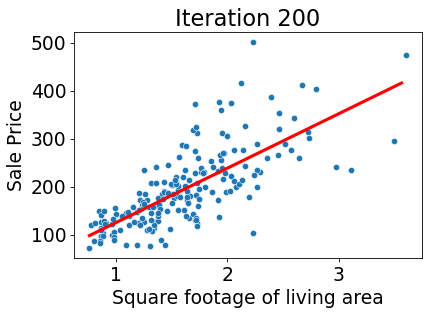

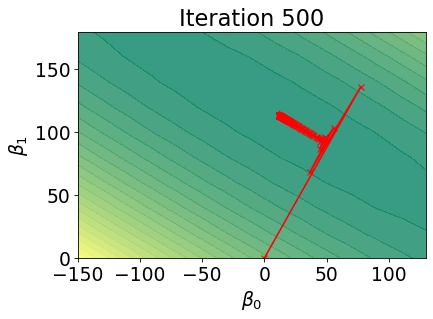

In [6]:
eta = 0.2# Step-size
T  = 500 # Number of iteration
beta = np.zeros(shape=(2,T))

for t in np.arange(0, T-1):    
    
    # Contour plot and current prediction rule
    if ((t<=5) or (t==100) or (t==200)):
        plt.figure()
        plt.contourf(b0_mg, b1_mg, Z, alpha = 0.8, levels=20, cmap=colormap)           
        plt.quiver(b0_mg, b1_mg,Z_grad1,Z_grad2, angles = 'xy')
        plt.xlabel(r'$\beta_0$')
        plt.ylabel(r'$\beta_1$') 
        plt.plot(beta[0,0:t+1], beta[1,0:t+1], marker='x', color='red', linestyle='dotted')
        plt.scatter(regr.intercept_,regr.coef_[0], marker='d', color='red')
        plt.title('Iteration '+str(t))
        plt.axis('equal')
        if svfigs:
            plt.savefig(svdir + 'gd1_'+str(t))

        plt.figure()
        b0 = beta[0,t]
        b1 = beta[1, t]
        sns.scatterplot(data=houseprices, x='GrLivArea', y='SalePrice') 
        plt.xlabel("Square footage of living area")
        plt.ylabel("Sale Price")
        x0 = np.arange(np.min(X), np.max(X), .1)
        y0 = b0+b1*x0
        plt.title('Iteration '+str(t))
        plt.plot(x0,y0, color='red', linewidth = 3)        
        if svfigs:
            plt.savefig(svdir + 'gd2_'+str(t))

    # Gradient descent update
    beta[:,[t+1]] = beta[:,[t]] - 2*eta/n* Phi.T @ (Phi @ beta[:,[t]] - y.reshape(-1,1))
    
plt.figure()
plt.contourf(b0_mg, b1_mg, Z, alpha = 0.8, levels=20, cmap=colormap)   
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$') 
plt.title('Iteration '+str(T))
plt.plot(beta[0,0:T], beta[1,0:T], marker='x', color='red')
plt.scatter(regr.intercept_,regr.coef_[0], marker='d', color='red')
if svfigs:
    plt.savefig(svdir + 'gd1_'+str(t))


## With normalisation

beta_0= 193.355935
beta_1= 59.01586132700582


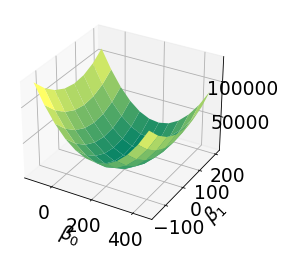

In [7]:
n = X.size
# Standardise the input first
X_normalised = (X-X.mean())/X.std()

# Fit a linear regression model (to show the minimum)
regr = linear_model.LinearRegression()
regr.fit(X_normalised.reshape(-1,1), y)
print('beta_0=', regr.intercept_)
print('beta_1=', regr.coef_[0])

# Show the empirical risk as a function of the two parameters
colormap = 'summer'
beta0_range = np.arange(-100,500, 50)
beta1_range = np.arange(-150,250, 50)

N, M = len(beta0_range), len(beta1_range)
Z = np.zeros((N, M))
Z_grad1 = np.zeros((N, M))
Z_grad2 = np.zeros((N, M))
for i, (beta0, beta1) in enumerate(product(beta0_range,beta1_range)):
    ypred = beta0+(X-X.mean())/X.std()*beta1
    Z[np.unravel_index(i, (N,M))] = ((y-ypred)**2).mean()
    Z_grad1[np.unravel_index(i, (N,M))] = (2*(ypred-y)).mean()
    Z_grad2[np.unravel_index(i, (N,M))] = (2*(X-X.mean())/X.std()*(ypred-y)).mean()
Z = Z.T
Z_grad1 = Z_grad1.T
Z_grad2 = Z_grad2.T

    
(b0_mg, b1_mg) = np.meshgrid(beta0_range, beta1_range)

plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(b0_mg, b1_mg, Z, rstride=1, cstride=1,edgecolor='none', cmap=colormap)   
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$') 
if svfigs:
    plt.savefig(svdir + 'housepricingemprisknormalised.png', bbox_inches = 'tight')

In [8]:
Phi = np.concatenate((np.ones(shape=(n, 1)), X_normalised.reshape(-1,1)),axis=1)
print('Phi^T Phi: \n', Phi.T @ Phi)

Phi^T Phi: 
 [[2.00000000e+02 6.65925648e-14]
 [6.65925648e-14 2.00000000e+02]]


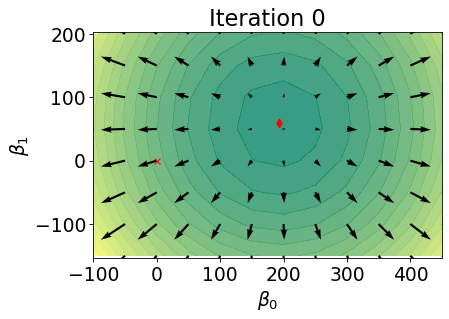

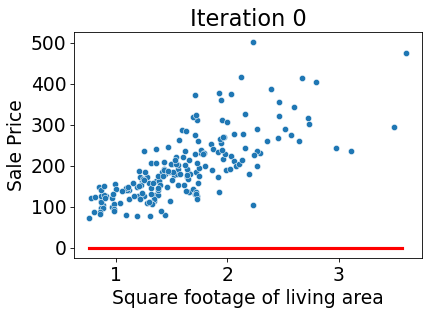

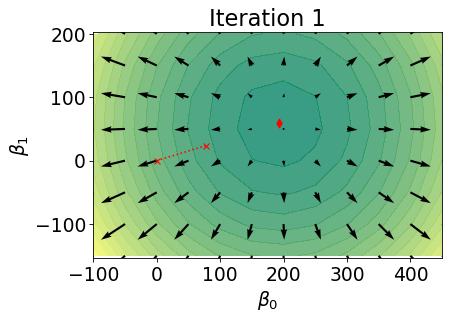

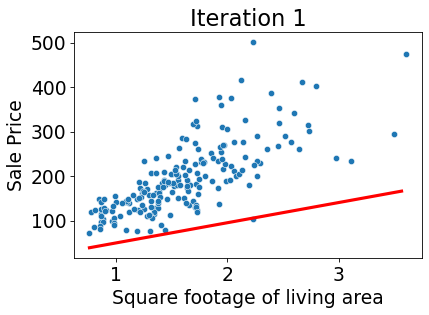

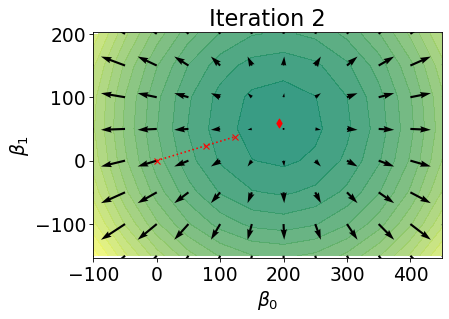

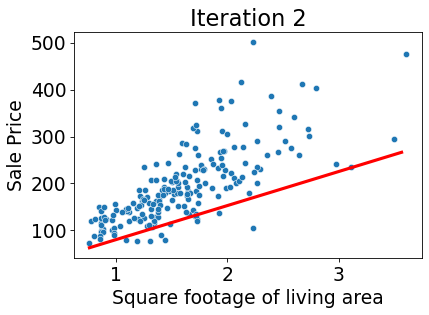

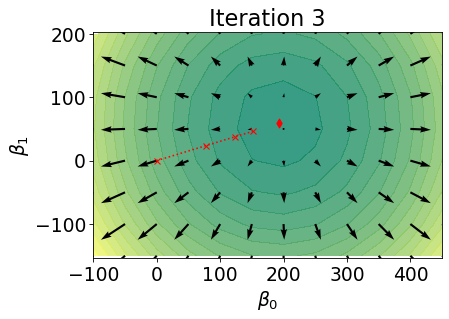

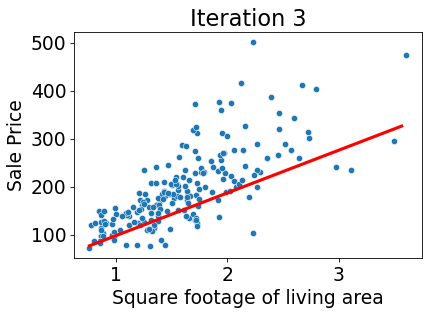

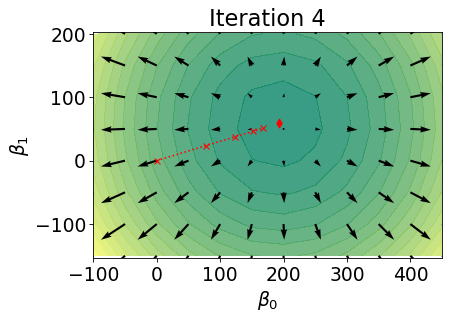

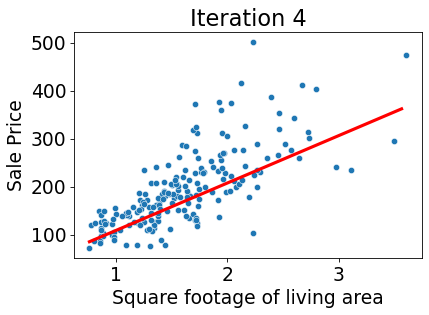

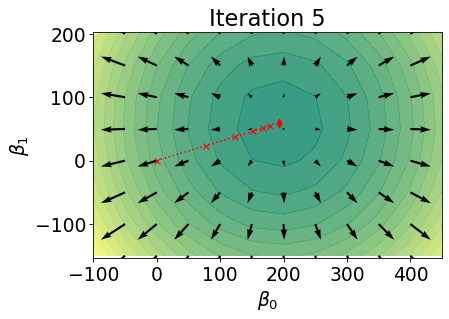

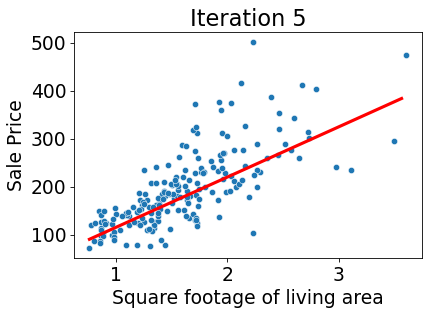

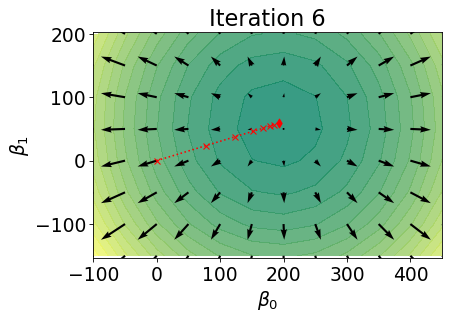

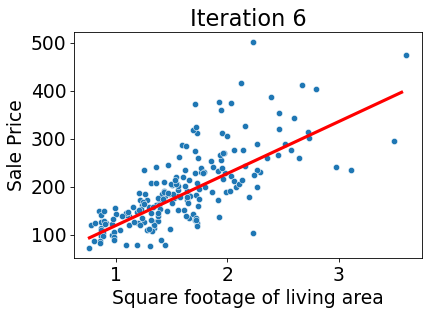

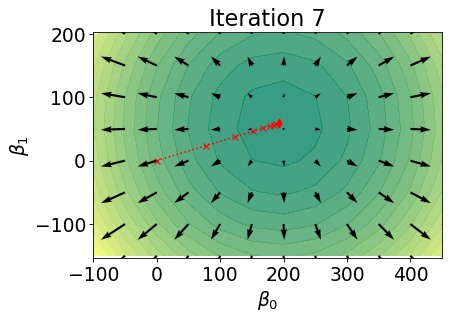

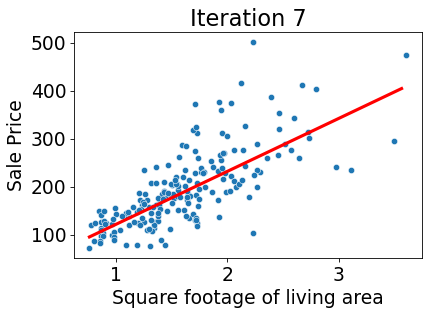

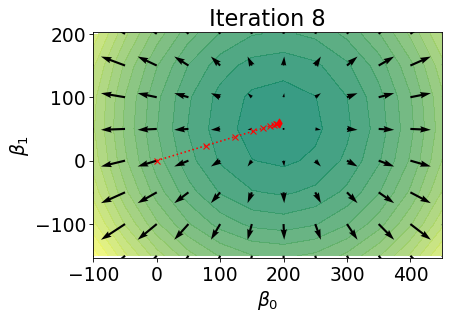

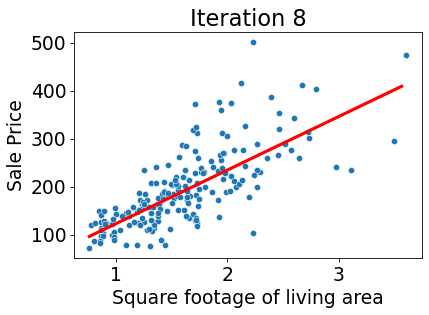

In [9]:
eta = 0.2 # Step size
T  = 10 # Number of iterations
beta = np.zeros(shape=(2,T))

for t in np.arange(0, T-1):
    
    # Some plots
    plt.figure()
    plt.contourf(b0_mg, b1_mg, Z, alpha = 0.8, levels=20, cmap=colormap)   
    plt.quiver(b0_mg, b1_mg,Z_grad1,Z_grad2, angles = 'xy')
    plt.xlabel(r'$\beta_0$')
    plt.ylabel(r'$\beta_1$') 
    plt.title('Iteration '+str(t))
    plt.scatter(regr.intercept_,regr.coef_[0], marker='d', color='red')
    plt.plot(beta[0,0:t+1], beta[1,0:t+1], marker='x', color='red', linestyle='dotted')
    plt.axis('equal')
    if svfigs:
        plt.savefig(svdir + 'gd1_norm_' + str(t))

    plt.figure()
    b0 = beta[0,t]
    b1 = beta[1, t]
    sns.scatterplot(data=houseprices, x='GrLivArea', y='SalePrice') 
    plt.xlabel("Square footage of living area")
    plt.ylabel("Sale Price")
    x0 = np.arange(np.min(X), np.max(X), .1)
    y0 = b0+b1*(x0-X.mean())/X.std()
    plt.plot(x0,y0, color='red', linewidth = 3)
    plt.title('Iteration '+str(t))
    if svfigs:
        plt.savefig(svdir + 'gd2_norm_' + str(t))
    
    # Gradient Descent update
    beta[:,[t+1]] = beta[:,[t]] - 2*eta/n* Phi.T @ (Phi @ beta[:,[t]] - y.reshape(-1,1))

# Stochastic gradient descent (batch size=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


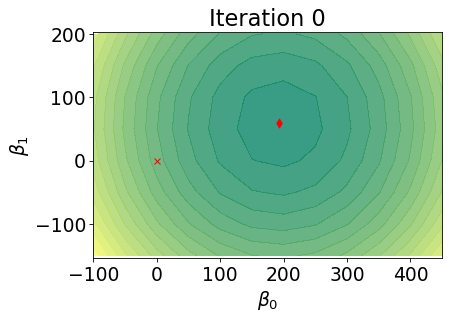

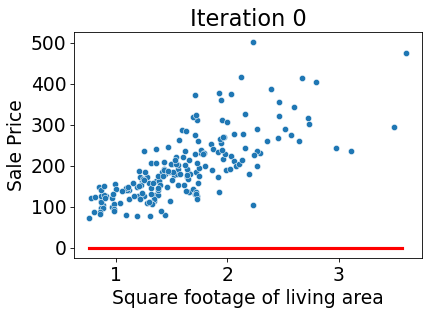

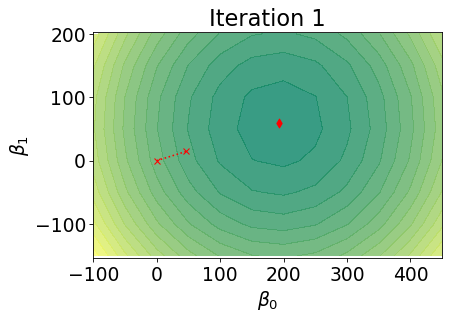

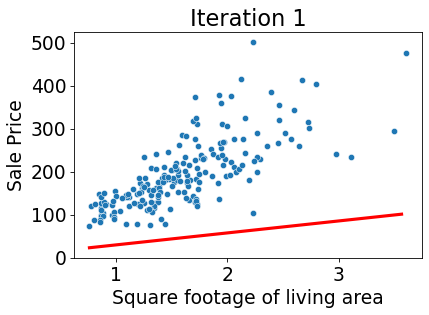

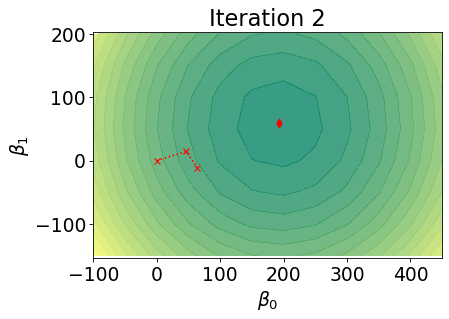

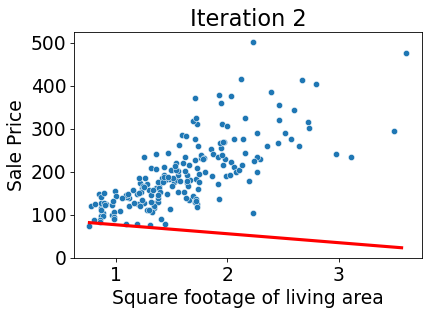

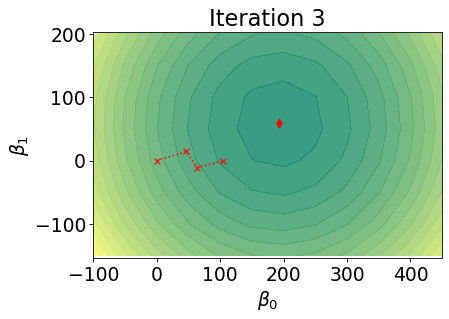

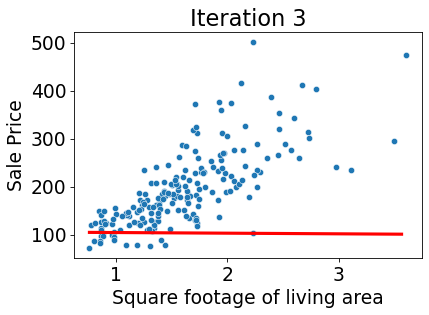

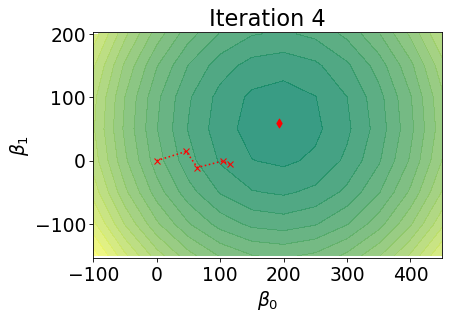

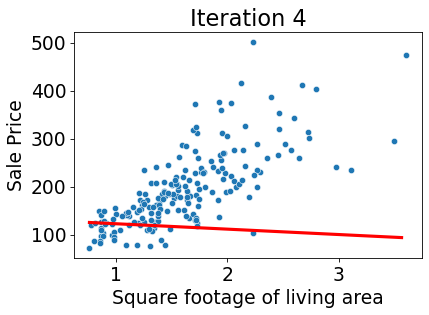

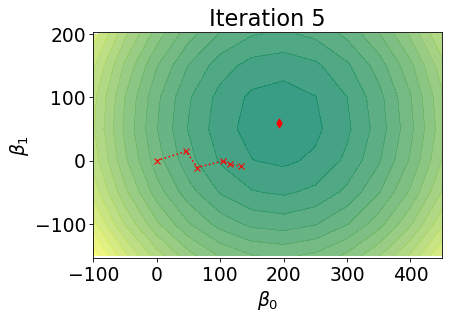

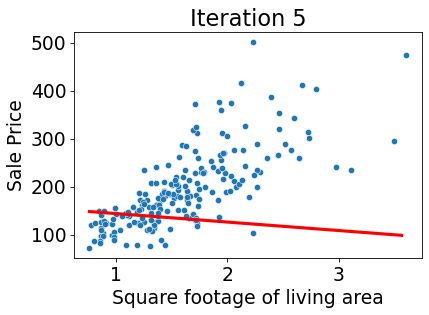

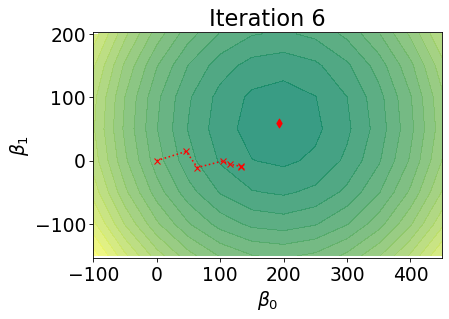

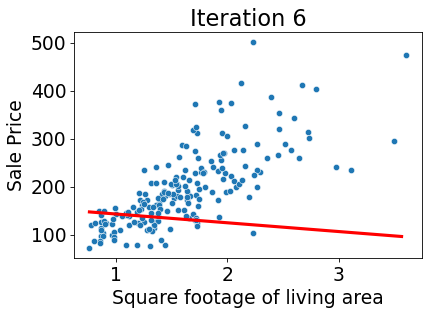

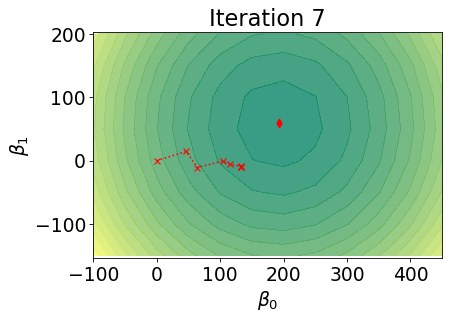

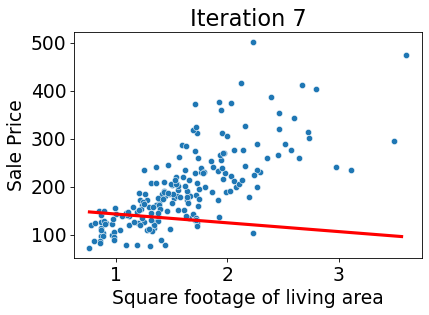

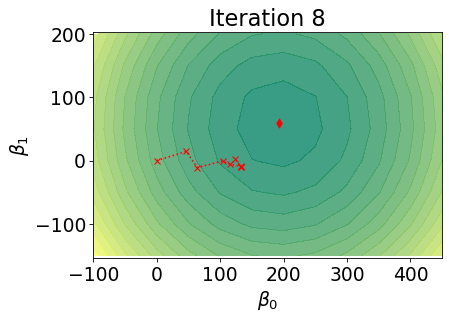

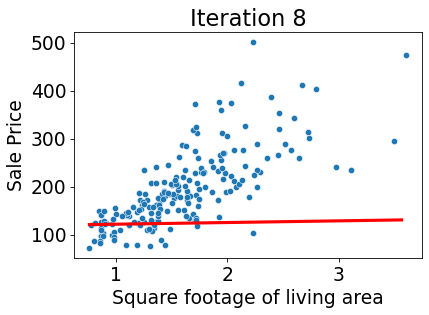

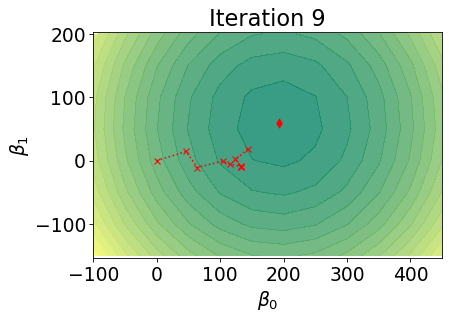

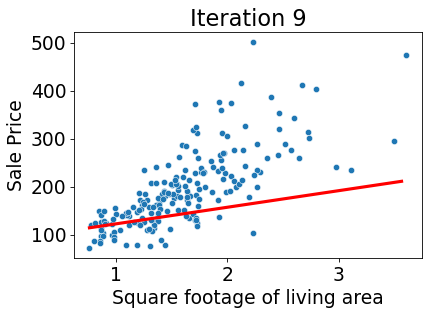

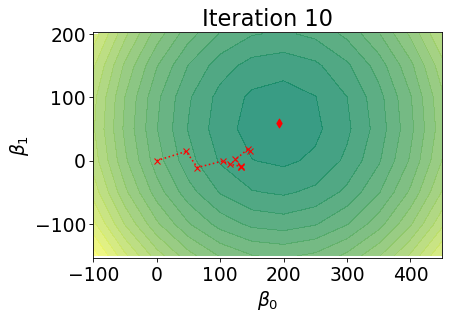

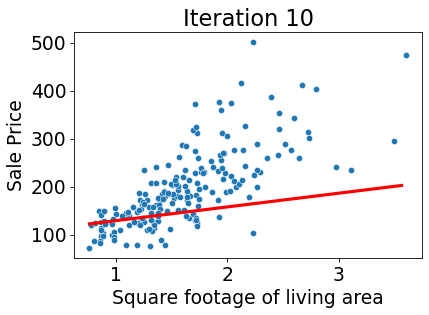

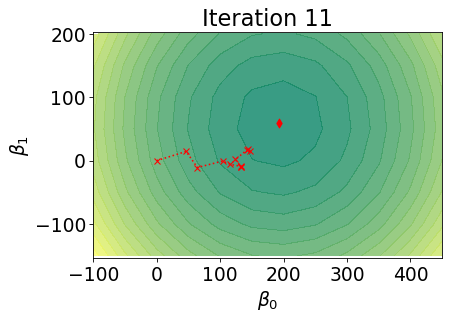

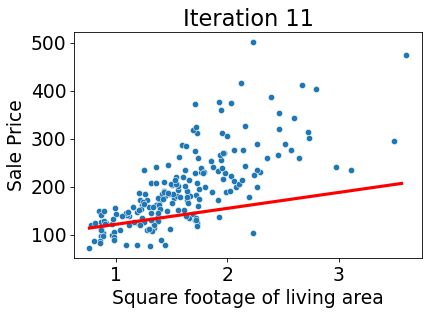

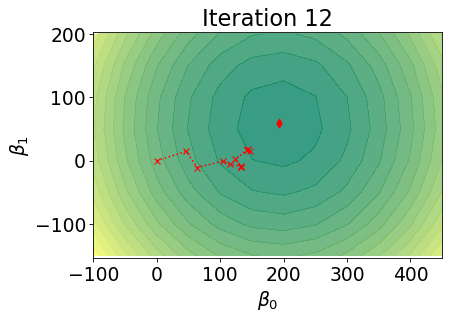

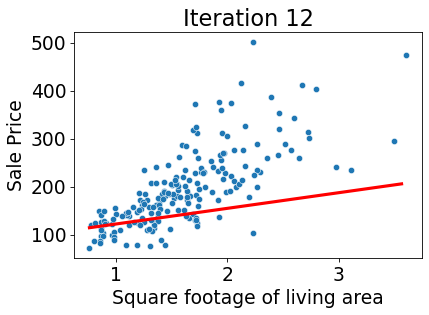

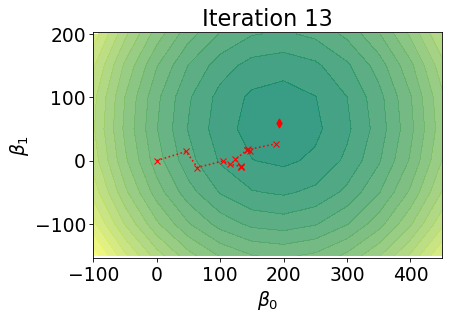

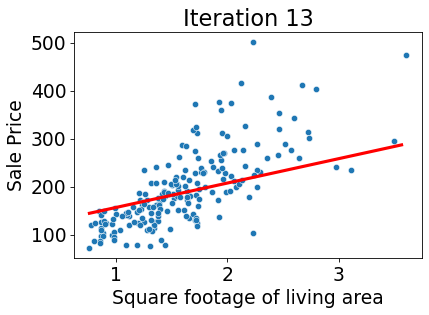

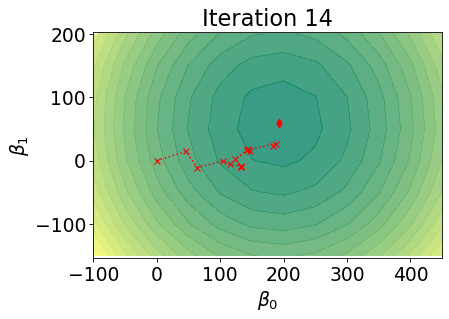

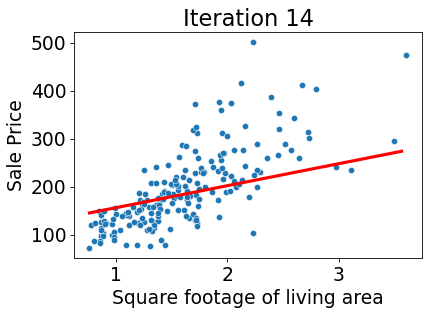

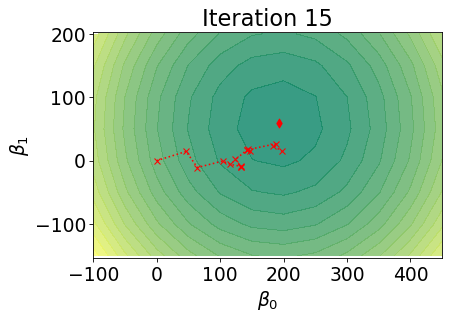

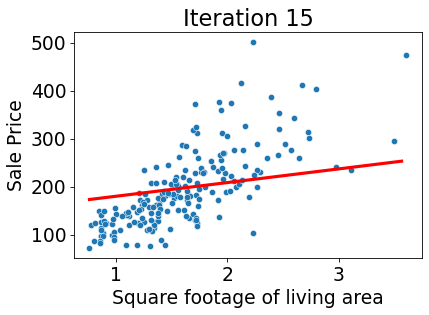

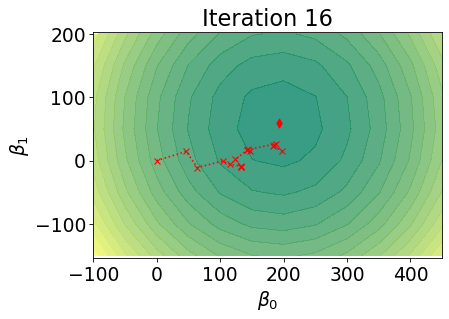

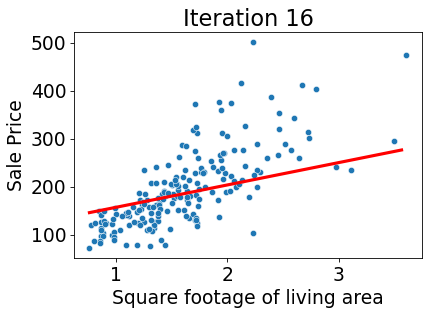

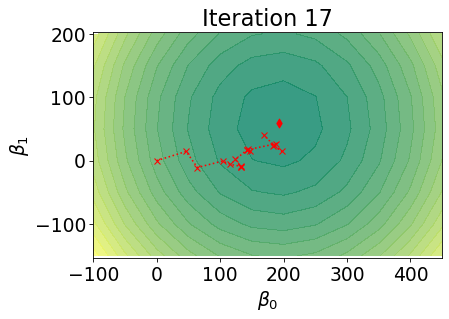

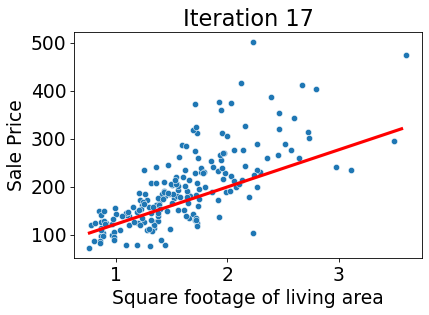

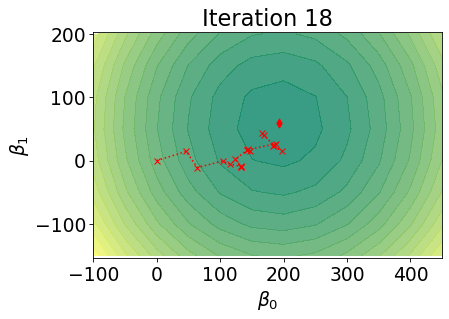

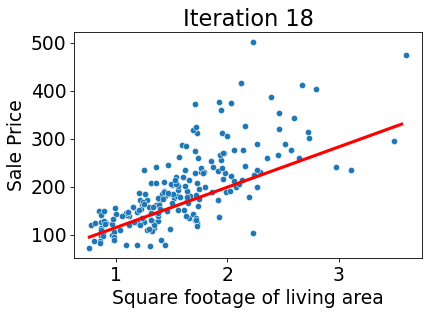

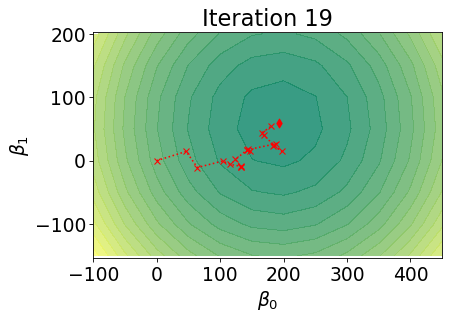

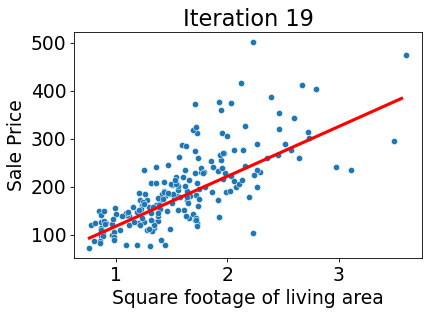

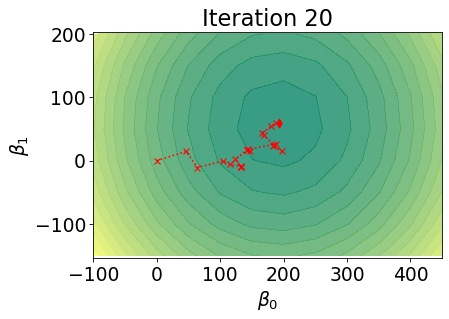

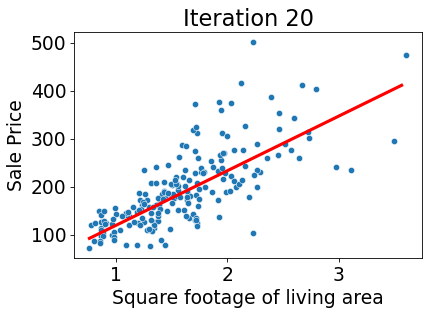

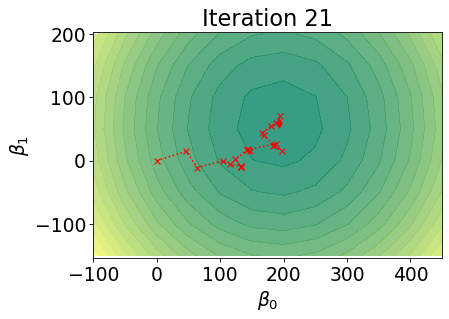

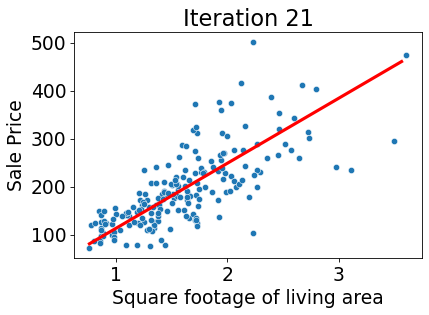

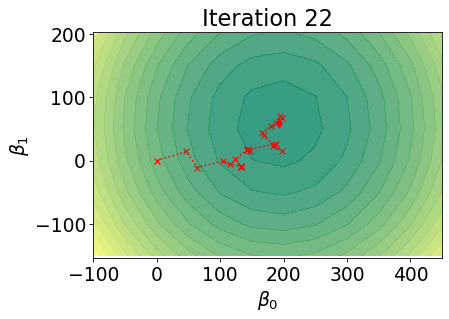

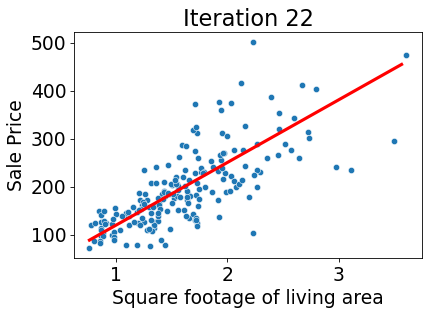

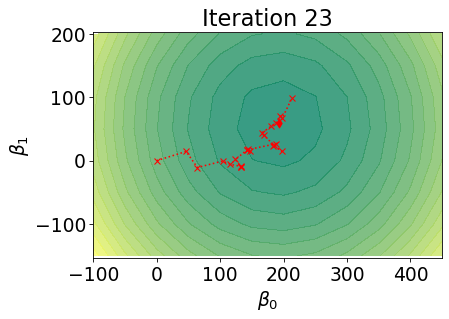

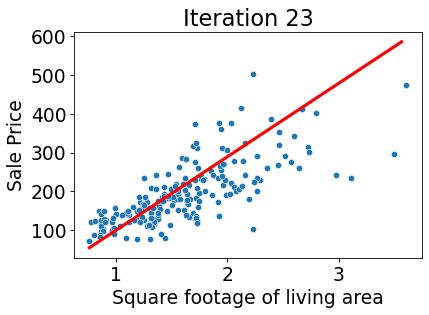

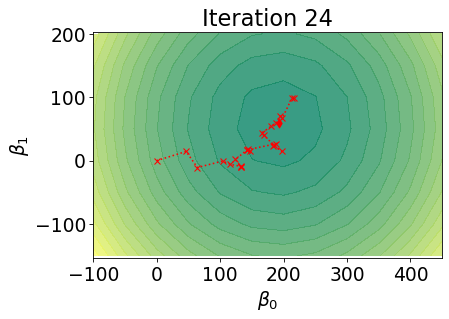

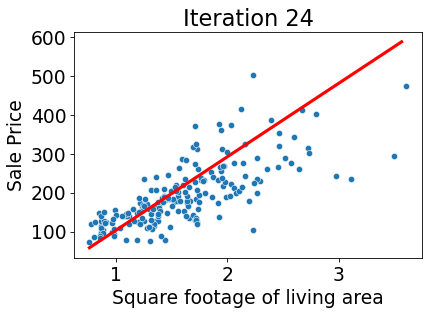

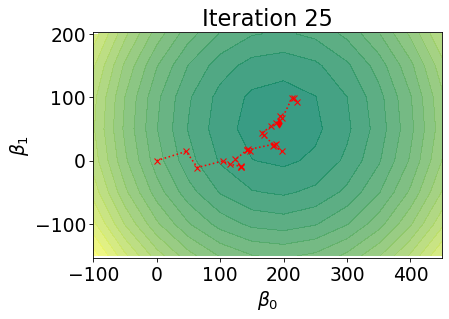

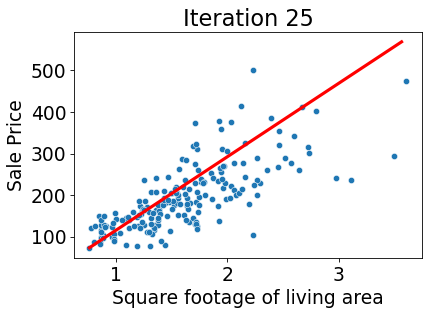

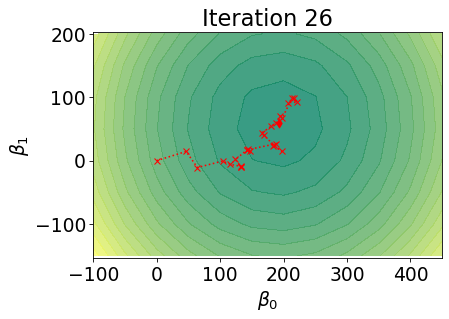

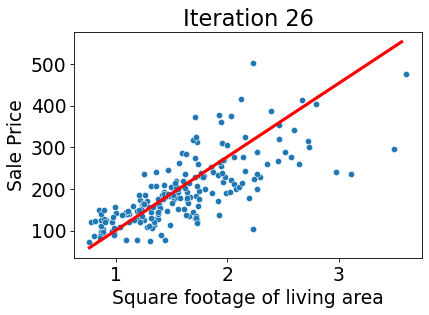

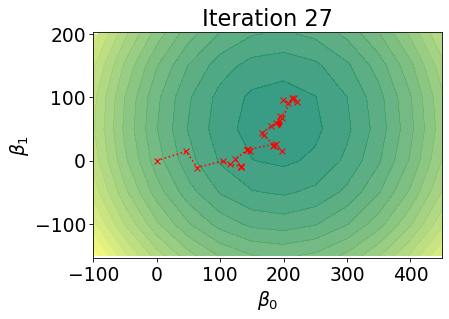

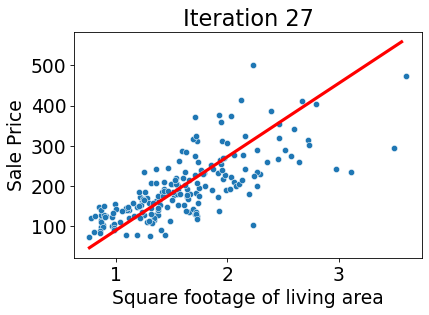

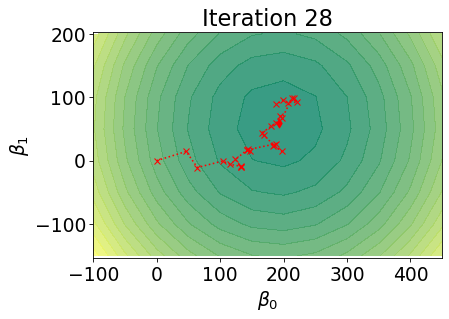

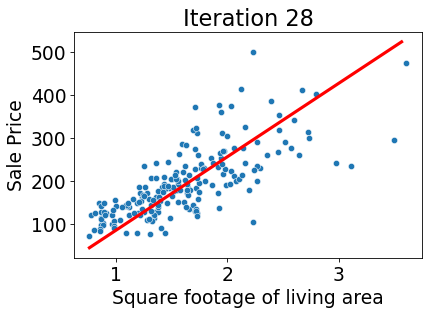

In [10]:
Phi = np.concatenate((np.ones(shape=(n, 1)), X_normalised.reshape(-1,1)), axis=1)
eta = 0.1 # Step size
T  = 30 # Number of iterations
beta = np.zeros(shape=(2,T))
for t in np.arange(0, T-1):    
    # Some plots
    plt.figure()
    cf = plt.contourf(b0_mg, b1_mg, Z, alpha = 0.8, levels=20, cmap=colormap)   
    plt.xlabel(r'$\beta_0$')
    plt.ylabel(r'$\beta_1$') 
    plt.scatter(regr.intercept_,regr.coef_[0], marker='d', color='red')
    plt.title('Iteration '+str(t))
    plt.plot(beta[0,0:t+1], beta[1,0:t+1], marker='x', color='red', linestyle='dotted')
    plt.axis('equal')
    if svfigs:
        plt.savefig(svdir + 'sgd1_norm_' + str(t))

    plt.figure()
    b0 = beta[0,t]
    b1 = beta[1, t]
    sns.scatterplot(data=houseprices, x='GrLivArea', y='SalePrice') 
    plt.xlabel("Square footage of living area")
    plt.ylabel("Sale Price")
    plt.title('Iteration '+str(t))
    x0 = np.arange(np.min(X), np.max(X), .1)
    y0 = b0+b1*(x0-X.mean())/X.std()
    plt.plot(x0,y0, color='red', linewidth = 3)
    if svfigs:
        plt.savefig(svdir + 'sgd2_norm_' + str(t))

    # SGD update
    beta[:,[t+1]] = beta[:,[t]] - 2*eta * Phi[[t],:].T @(Phi[[t],:] @ beta[:,[t]] - y[t])


# Gradient descent, Early stopping and implicit regularisation

Size of X_train, y_train: (100,) (100,)
Size of X_val, y_val: (50,) (50,)
Size of X_test, y_test: (50,) (50,)


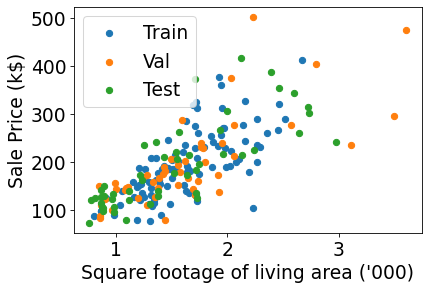

In [11]:
# Split into training/validation/test set
prop_train = 0.5
prop_val = 0.25
prop_test = 0.25

# Split between train/val and test
X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(X, y, test_size=prop_test, random_state=12)
# Split between train and val
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainval, y_trainval, test_size=prop_val/(prop_val+prop_train), random_state=12)

print('Size of X_train, y_train:',X_train.shape, y_train.shape)
print('Size of X_val, y_val:',X_val.shape, y_val.shape)
print('Size of X_test, y_test:',X_test.shape, y_test.shape)

plt.figure()
plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)
plt.scatter(X_test, y_test)
plt.legend(['Train', 'Val', 'Test'])
plt.xlabel("Square footage of living area ('000)")
plt.ylabel("Sale Price (k$)")
if svfigs:
    plt.savefig(svdir + 'housepricingdatatrainvaltest.png', bbox_inches = 'tight')

In [12]:
# Use Polynomial features and rescale (except column of 1's)

M = 12 # Degree of the polynomial

# Generate polynomial features
poly_reg = PolynomialFeatures(degree=M)
X_train_poly = poly_reg.fit_transform(X_train.reshape(-1,1))
X_val_poly = poly_reg.fit_transform(X_val.reshape(-1,1))
X_test_poly = poly_reg.fit_transform(X_test.reshape(-1,1))

# Rescale data
scaler = StandardScaler().fit(X_train_poly[:,1:M+1])# scale all but the first column (of 1)
X_train_poly_scaled = np.concatenate([X_train_poly[:,[0]], scaler.transform(X_train_poly[:,1:M+1])], axis=1)
X_val_poly_scaled = np.concatenate([X_val_poly[:,[0]], scaler.transform(X_val_poly[:,1:M+1])], axis=1)
X_test_poly_scaled = np.concatenate([X_test_poly[:,[0]], scaler.transform(X_test_poly[:,1:M+1])], axis=1)

n_train = X_train_poly_scaled.shape[0]
X_train_poly_scaled.std(axis=0);

Approximated true Risk of learned predictor: 13107.621459246435


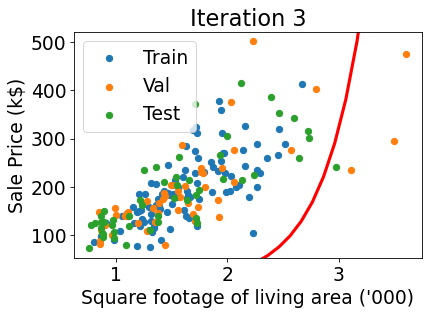

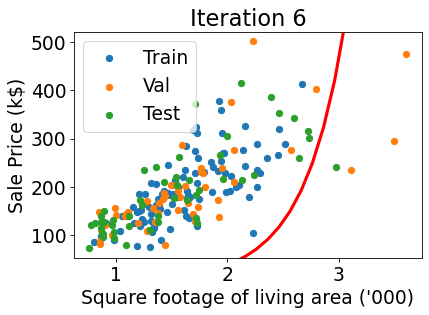

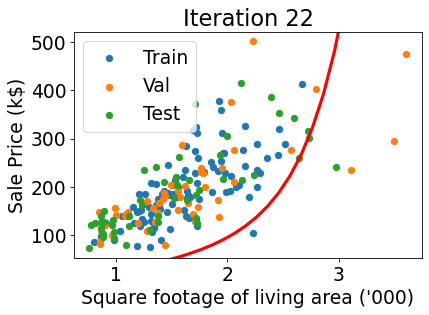

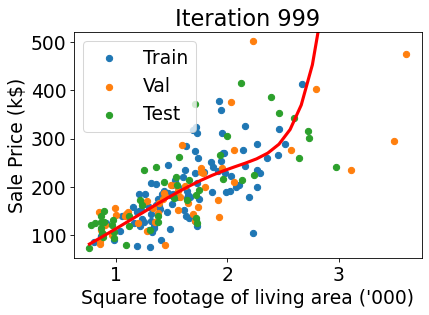

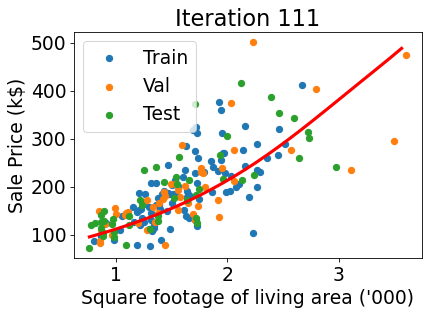

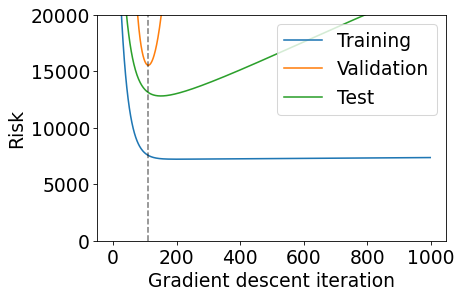

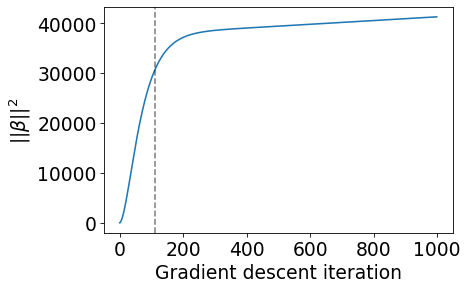

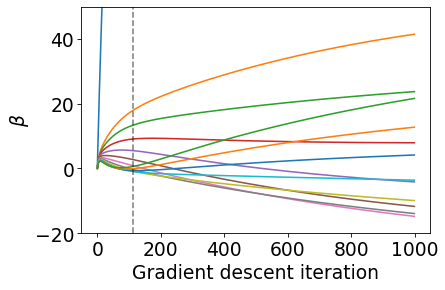

In [13]:
eta = 0.01
T  = 1000 # 200
beta = np.zeros(shape=(M+1,T))
testrisk= np.empty(shape=T)
valrisk= np.empty(shape=T)
emprisk = np.empty(shape=T)

# XtX = X_train_poly_scaled.T @ X_train_poly_scaled
# Xty = X_train_poly_scaled.T @ y_train.reshape(-1,1)

valrisk[0] = ((y_val - X_val_poly_scaled @ beta[:,[0]]) ** 2).mean() #  Validation risk
emprisk[0] = ((y_train - X_train_poly_scaled @ beta[:,[0]]) ** 2).mean() # Training risk
testrisk[0] = ((y_test - X_test_poly_scaled @ beta[:,[0]]) ** 2).mean() #  Validation risk

for t in np.arange(0, T-1):
    # Gradient descent update
    beta[:,[t+1]] = beta[:,[t]] - 2*eta/n_train* X_train_poly_scaled.T @ (X_train_poly_scaled @ beta[:,[t]] - y_train.reshape(-1,1))
    
    # Compute ERM and the associated true and empirical risk
    valrisk[t+1] = ((y_val - X_val_poly_scaled @ beta[:,[t+1]]) ** 2).mean() #  Validation risk
    emprisk[t+1] = ((y_train - X_train_poly_scaled @ beta[:,[t+1]]) ** 2).mean() # Training risk
    testrisk[t+1] = ((y_test - X_test_poly_scaled @ beta[:,[t+1]]) ** 2).mean() #  Validation risk
    
    # Some plots
    if ((t==2) or (t==5) or (t==21) or (t==T-2)):
        plt.figure()
        plt.scatter(X_train, y_train)
        plt.scatter(X_val, y_val)
        plt.scatter(X_test, y_test)
        plt.legend(['Train', 'Val', 'Test'])
        plt.xlabel("Square footage of living area ('000)")
        plt.ylabel("Sale Price (k$)")
        x0 = np.arange(np.min(X), np.max(X), .1)
        x0_poly = poly_reg.fit_transform(x0.reshape(-1,1))
        x0_poly_scaled = np.concatenate([x0_poly[:,[0]], scaler.transform(x0_poly[:,1:M+1])], axis=1)
        y0 = x0_poly_scaled @ beta[:,[t+1]]
        plt.title('Iteration '+str(t+1))
        plt.ylim([np.min(y)-20, np.max(y)+20])
        plt.plot(x0,y0, color='red', linewidth = 3)
        if svfigs:
            plt.savefig(svdir + 'housepricingdataGDearly1_' +  str(t)  + '.png', bbox_inches = 'tight')

# Find best prediction rule using the validation risk
T_hat = np.argmin(valrisk)
beta_hat = beta[:,[T_hat]]
# Approximate the true risk using the test set
truerisk_hat = testrisk[T_hat]
print('Approximated true Risk of learned predictor:', truerisk_hat)

# Plot the learned prediction rule
plt.figure()
plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)
plt.scatter(X_test, y_test)
plt.legend(['Train', 'Val', 'Test'])
plt.xlabel("Square footage of living area ('000)")
plt.ylabel("Sale Price (k$)")
x0 = np.arange(np.min(X), np.max(X), .1)
x0_poly = poly_reg.fit_transform(x0.reshape(-1,1))
x0_poly_scaled = np.concatenate([x0_poly[:,[0]], scaler.transform(x0_poly[:,1:M+1])], axis=1)
y0 = x0_poly_scaled @ beta[:,[T_hat]]
plt.title('Iteration '+str(T_hat))
plt.plot(x0,y0, color='red', linewidth = 3)
if svfigs:
    plt.savefig(svdir + 'housepricingdataGDearly1.png', bbox_inches = 'tight')


    
plt.figure()
plt.plot(emprisk)
plt.plot(valrisk)
plt.plot(testrisk)
plt.legend(['Training', 'Validation', 'Test'])
plt.xlabel('Gradient descent iteration')
plt.ylabel('Risk')
plt.axvline(x=T_hat, color='black', linestyle='dashed', alpha=0.5)
plt.ylim([0,20000])
if svfigs:
    plt.savefig(svdir + 'housepricingdataGDearly2.png', bbox_inches = 'tight')


plt.figure()
plt.plot((beta**2).sum(axis=0))
plt.xlabel('Gradient descent iteration')
plt.ylabel(r'$||\beta||^2$')
plt.axvline(x=T_hat, color='black', linestyle='dashed', alpha=0.5)
if svfigs:
    plt.savefig(svdir + 'housepricingdataGDearly3.png', bbox_inches = 'tight')

plt.figure()
plt.plot(beta.transpose())
plt.xlabel('Gradient descent iteration')
plt.ylabel(r'$\beta$')
plt.ylim(-20,50)
plt.axvline(x=T_hat, color='black', linestyle='dashed', alpha=0.5)
if svfigs:
    plt.savefig(svdir + 'housepricingdataGDearly4.png', bbox_inches = 'tight')